# Preamble

In [3]:
# data processing, EDA, and visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import os

# os.environ["OMP_NUM_THREADS"] = "6"                               # this is for K-Means

# sklearn libraries, preprocessing steps, and ML models
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from skelm import ELMClassifier
from sklearn import set_config

# hyperparameter tuning nnd model evaluation
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# MLflow
from mlflow import set_tracking_uri, set_experiment, start_run, log_params, log_metric
import mlflow.sklearn
from mlflow.sklearn import log_model, load_model

In [4]:
# configure central repo for this project
mlflow.set_tracking_uri(
    "file:///C://Users//gtapa//Desktop//SDSU//Fall 2025//BDA 602//Final Project//mlruns"
)

# set experiment name
mlflow.set_experiment("BDA 602 Final Project (Batch Corrected)")

<Experiment: artifact_location=('file:///C://Users//gtapa//Desktop//SDSU//Fall 2025//BDA 602//Final '
 'Project//mlruns/186282342878813459'), creation_time=1758847068395, experiment_id='186282342878813459', last_update_time=1758847068395, lifecycle_stage='active', name='BDA 602 Final Project (Batch Corrected)', tags={}>

# Importing the Data

In [6]:
data_dir = "C://Users//gtapa//Desktop//SDSU//Fall 2025//BDA 602//Final Project//Data//dataverse_files" # this is my own filepath, replace this with your own
os.chdir(data_dir)
os.getcwd()

'C:\\Users\\gtapa\\Desktop\\SDSU\\Fall 2025\\BDA 602\\Final Project\\Data\\dataverse_files'

In [7]:
# this file gives the names and type (oral or gut) of each MSP, along with the MSP code
ref_table_file = "MSP_set_ref_oss_gss_status_612_ref_paper_20250220_gtdb_220.tsv"

# this file is the raw data we will be using, this will be merged with other columns to provide more information
signal_count_file = "batch_effect_corrected_species_filtered0_2340_ech//species_signal_2340_CRC_cohort_20240617_plsda_prev0.csv"

# this is the metadata file containing the labels for each stool sample (patient) that will be used for supervised training
# also note that this is originally an Excel file, but was converted into a CSV
metadata_file = "metadata_2340_CRC_cohort_20240704//metadata_2340_CRC_cohort_20240704.csv"

In [8]:
ref_table = pd.read_csv(ref_table_file, sep = "\t")
signal_count = pd.read_csv(signal_count_file, sep = "\t")
signal_count = signal_count.T                                                   # the original file has the MSPs on the rows and the samples on the columns, the transpose makes it easier to understand
metadata = pd.read_csv(metadata_file)

In [9]:
ref_table.head()

,msp_name_corrected,itol,ref_MSP,msp_id,catalogue,size,completeness,cultured,oxygen,opp_path,MSP_class,gtdb_r220_classification,superkingdom,phylum,class,order,family,genus,species,msp
0,msp_0001_hs,y,gut,msp_0001,gut,14947,NaN,True,0.0,NaN,gss,d__Eukaryota;p__Heterokonta;c__Blastocystae;o_...,Eukaryota,Heterokonta,Blastocystae,Blastocystida,Blastocystidae,Blastocystis,Blastocystis sp. subtype 3,msp_0001
1,msp_0002_hs,y,gut,msp_0002,gut,11854,NaN,True,0.0,NaN,gut,d__Eukaryota;p__Heterokonta;c__Blastocystae;o_...,Eukaryota,Heterokonta,Blastocystae,Blastocystida,Blastocystidae,Blastocystis,Blastocystis sp. subtype 1,msp_0002
2,msp_0003_hs,y,gut,msp_0003,gut,14853,100.00,True,0.0,NaN,gss,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides cellulosilyticus,msp_0003
3,msp_0004_hs,y,gut,msp_0004,gut,11112,NaN,True,0.0,NaN,gut,d__Eukaryota;p__Heterokonta;c__Blastocystae;o_...,Eukaryota,Heterokonta,Blastocystae,Blastocystida,Blastocystidae,Blastocystis,Blastocystis sp. subtype 2,msp_0004
4,msp_0005_hs,y,gut,msp_0005,gut & oral,12508,95.92,True,1.0,1.0,gss,d__Bacteria;p__Pseudomonadota;c__Gammaproteoba...,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Escherichia,Escherichia coli,msp_0005


In [10]:
ref_table['ref_MSP'].value_counts()

ref_MSP
gut     1903
oral     640
Name: count, dtype: int64

In [11]:
signal_count.columns = signal_count.iloc[0]
signal_count = signal_count.drop(signal_count.index[0])                         # this is to promote the top row to the column headers, makes later merging less frustrating
signal_count.head()

msp_id,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2943,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957
SRS17441337,-1.029962,-1.037837,14.80546,-1.500935,18.654781,-1.14538,16.846779,-0.018692,16.738896,22.815145,...,6.939011,7.882015,-1.573128,-1.37872,-1.601568,-1.610274,7.504587,-0.172769,-2.026779,-1.574182
SRS17441336,-3.373199,-2.099562,11.883152,-2.397033,14.672665,13.206495,15.093825,1.039253,4.367989,3.001589,...,3.553514,7.300464,-1.505154,-1.267283,-1.514215,-1.515666,-4.846438,-0.064983,-1.749895,-1.453683
SRS17441335,-0.84282,-1.527343,-0.670177,-1.26845,14.229914,-1.28059,19.649271,19.065704,11.803231,19.007433,...,1.982005,3.142812,-1.418665,-1.308269,-1.453995,-1.465336,-2.703009,-0.428463,-1.459596,-1.481144
SRS17441334,-1.146332,-1.040809,0.747987,-1.669717,18.497992,-1.537679,0.761387,4.390679,15.420604,4.469198,...,3.359216,7.077018,-1.654947,-1.556514,-1.735765,-1.717508,-3.853704,-0.705506,-1.761091,-1.719143
SRS17441333,-0.831826,-0.792026,-1.340669,-1.597376,18.536155,15.408249,14.95448,2.945806,12.798529,1.146454,...,2.064611,5.588305,-1.522393,-1.382141,-1.58434,-1.564337,-4.38036,-0.222396,-1.624677,-1.569672


In [12]:
metadata = metadata.set_index("sample")
metadata.head()

,HQ_clean_read_count,gut_mapped_read_count,gut_mapped_pc,oral_mapped_read_count,oral_mapped_pc,MGS,low_read,low_map,excluded,excluded_comment,...,body_site,body_subsite,health_status,host_phenotype,host_subphenotype,gender,age,bmi,class,to_exclude
sample,,,,,,,,,,,,,,,,,,,,,
SRS17441337,47916688,36915908,77.041861,7031971,14.675411,311,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,female,71.0,27.343750,CRC,NaN
SRS17441336,60552974,49696859,82.071706,2905675,4.798567,411,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,male,58.0,27.681661,CRC,NaN
SRS17441335,48171808,41489574,86.128330,3307205,6.865437,188,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,female,74.0,24.524346,CRC,NaN
SRS17441334,37323584,29266453,78.412762,1714205,4.592820,260,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,female,76.0,18.611496,CRC,NaN
SRS17441333,33594648,25139320,74.831324,1777330,5.290515,227,NaN,NaN,NaN,NaN,...,gut,stool,P,CRC,NaN,male,76.0,31.708284,CRC,NaN


# Data Preprocessing

## Generating a Metadata Report

In [15]:
def create_metadata(df):
  meta_report = pd.DataFrame(index=df.columns)
  meta_report['dtype'] = df.dtypes
  meta_report['n_unique'] = df.nunique()
  meta_report['n_missing'] = df.isnull().sum()
  meta_report['pct_missing'] = meta_report['n_missing'] / df.shape[0]
  meta_report['n_duplicates'] = df.duplicated().sum()
  meta_report['pct_duplicates'] = meta_report['n_duplicates'] / df.shape[0]
  meta_report['is_numeric'] = meta_report['dtype'].apply(
      lambda x: pd.api.types.is_numeric_dtype(x)
  )
  meta_report['is_categorical'] = meta_report['dtype'].apply(
      lambda x: isinstance(x, pd.CategoricalDtype) or x == object
  )
  return meta_report

In [16]:
create_metadata(signal_count)

,dtype,n_unique,n_missing,pct_missing,n_duplicates,pct_duplicates,is_numeric,is_categorical
msp_id,,,,,,,,
msp_0001,object,2340,0,0.0,0,0.0,False,True
msp_0002,object,2340,0,0.0,0,0.0,False,True
msp_0003,object,2340,0,0.0,0,0.0,False,True
msp_0004,object,2340,0,0.0,0,0.0,False,True
msp_0005,object,2340,0,0.0,0,0.0,False,True
...,...,...,...,...,...,...,...,...
msp_2948,object,2340,0,0.0,0,0.0,False,True
msp_2949,object,2340,0,0.0,0,0.0,False,True
msp_2950,object,2340,0,0.0,0,0.0,False,True


## Coercing Features to Integer Types

In [18]:
for col in signal_count.columns:
  signal_count[col] = pd.to_numeric(signal_count[col], errors='coerce')

In [19]:
create_metadata(signal_count)

,dtype,n_unique,n_missing,pct_missing,n_duplicates,pct_duplicates,is_numeric,is_categorical
msp_id,,,,,,,,
msp_0001,float64,2340,0,0.0,0,0.0,True,False
msp_0002,float64,2340,0,0.0,0,0.0,True,False
msp_0003,float64,2340,0,0.0,0,0.0,True,False
msp_0004,float64,2340,0,0.0,0,0.0,True,False
msp_0005,float64,2340,0,0.0,0,0.0,True,False
...,...,...,...,...,...,...,...,...
msp_2948,float64,2340,0,0.0,0,0.0,True,False
msp_2949,float64,2340,0,0.0,0,0.0,True,False
msp_2950,float64,2340,0,0.0,0,0.0,True,False


## Separating the MSPs into Gut and Oral Tables

In [21]:
# separate the gut and oral MSPs into different tables
catalogue = signal_count.T.merge(ref_table[['msp_id', 'ref_MSP']], on='msp_id')

gut_signal_count = catalogue[(catalogue.ref_MSP == "gut")]
oral_signal_count = catalogue[(catalogue.ref_MSP == "oral")]

In [22]:
print(gut_signal_count.shape)
print(oral_signal_count.shape)

(1903, 2342)
(640, 2342)


In [23]:
# drop the catalogue column for each table
gut_signal_count = gut_signal_count.drop(columns = ["ref_MSP"])
oral_signal_count = oral_signal_count.drop(columns = ["ref_MSP"])

In [24]:
# this will promote the top row to the column headers
gut_signal_count = gut_signal_count.T
gut_signal_count.columns = gut_signal_count.iloc[0]
gut_signal_count = gut_signal_count.drop(gut_signal_count.index[0])

oral_signal_count = oral_signal_count.T
oral_signal_count.columns = oral_signal_count.iloc[0]
oral_signal_count = oral_signal_count.drop(oral_signal_count.index[0])

In [25]:
gut_signal_count.head()

msp_id,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2176,msp_2178,msp_2180,msp_2191,msp_2195,msp_2196,msp_2207,msp_2209,msp_2210,msp_2211
SRS17441337,-1.029962,-1.037837,14.80546,-1.500935,18.654781,-1.14538,16.846779,-0.018692,16.738896,22.815145,...,-1.589878,-1.509416,-1.627022,-1.6295,-1.552988,-1.691007,-1.524782,-1.637753,-1.474846,-1.646371
SRS17441336,-3.373199,-2.099562,11.883152,-2.397033,14.672665,13.206495,15.093825,1.039253,4.367989,3.001589,...,-1.502913,-1.488438,-1.561049,-1.640168,-1.497144,-1.55282,-1.572653,-1.444756,-1.322628,-1.535853
SRS17441335,-0.84282,-1.527343,-0.670177,-1.26845,14.229914,-1.28059,19.649271,19.065704,11.803231,19.007433,...,-1.449847,-1.380011,-1.505241,-1.448118,-1.423416,-1.516077,-1.763271,-1.498684,-1.479147,-1.427459
SRS17441334,-1.146332,-1.040809,0.747987,-1.669717,18.497992,-1.537679,0.761387,4.390679,15.420604,4.469198,...,-1.696844,-1.570944,-1.870282,-1.762796,-1.689926,-1.82268,12.176931,-1.732469,-1.80077,-1.732937
SRS17441333,-0.831826,-0.792026,-1.340669,-1.597376,18.536155,15.408249,14.95448,2.945806,12.798529,1.146454,...,-1.562583,-1.524964,-1.662054,-1.602348,-1.492507,-1.706279,-1.898948,-1.483518,-1.712402,-1.621982


In [26]:
for col in gut_signal_count.columns:
  gut_signal_count[col] = pd.to_numeric(gut_signal_count[col], errors='coerce')

In [27]:
for col in oral_signal_count.columns:
  oral_signal_count[col] = pd.to_numeric(oral_signal_count[col], errors='coerce')

## Joining the Metadata Labels to the Tables

In [29]:
# joining the metadata labels to the signal_count table
signal_count = signal_count.join(metadata[['class', 'to_exclude']], how='left')

In [30]:
signal_count = signal_count[signal_count.to_exclude != 'yes']                   # some samples were contaminated, per the to_exclude metadata column
                                                                                # now, this table only includes non-contaminated samples

In [31]:
signal_count = signal_count.drop(columns = ["to_exclude"])
signal_count

,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957,class
SRS17441337,-1.029962,-1.037837,14.805460,-1.500935,18.654781,-1.145380,16.846779,-0.018692,16.738896,22.815145,...,7.882015,-1.573128,-1.378720,-1.601568,-1.610274,7.504587,-0.172769,-2.026779,-1.574182,CRC
SRS17441336,-3.373199,-2.099562,11.883152,-2.397033,14.672665,13.206495,15.093825,1.039253,4.367989,3.001589,...,7.300464,-1.505154,-1.267283,-1.514215,-1.515666,-4.846438,-0.064983,-1.749895,-1.453683,CRC
SRS17441335,-0.842820,-1.527343,-0.670177,-1.268450,14.229914,-1.280590,19.649271,19.065704,11.803231,19.007433,...,3.142812,-1.418665,-1.308269,-1.453995,-1.465336,-2.703009,-0.428463,-1.459596,-1.481144,CRC
SRS17441334,-1.146332,-1.040809,0.747987,-1.669717,18.497992,-1.537679,0.761387,4.390679,15.420604,4.469198,...,7.077018,-1.654947,-1.556514,-1.735765,-1.717508,-3.853704,-0.705506,-1.761091,-1.719143,CRC
SRS17441333,-0.831826,-0.792026,-1.340669,-1.597376,18.536155,15.408249,14.954480,2.945806,12.798529,1.146454,...,5.588305,-1.522393,-1.382141,-1.584340,-1.564337,-4.380360,-0.222396,-1.624677,-1.569672,CRC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DRS087523,-2.044121,-1.760400,15.650100,-1.521147,13.029882,-0.752994,12.109070,-1.323924,-1.822938,-1.043408,...,6.718252,-1.476485,-1.535637,-1.473856,-1.461386,-0.650576,-2.108248,-1.422208,-1.459407,healthy
DRS087522,-2.182059,-1.316857,9.128830,-1.773406,14.622287,-1.336074,15.833801,-4.350012,14.998622,14.894068,...,11.214401,-1.568908,-1.662746,-1.579050,-1.603088,11.207083,-1.799427,-1.581584,-1.587402,CRC
DRS087521,-0.693154,-1.182697,20.350629,-1.219606,12.323107,-1.207896,-1.784272,1.596607,12.020043,0.110470,...,-0.450892,-1.507655,-1.338247,-1.518717,-1.505177,10.009484,-1.055317,-1.472775,-1.500760,CRC
DRS087520,-0.641862,-1.465175,15.043082,-1.259632,18.647776,-1.313289,12.297714,1.566905,11.177305,-1.537394,...,7.991768,-1.442185,-1.444439,-1.505848,-1.447988,-1.617435,-1.625064,-1.436483,-1.464437,CRC


In [32]:
gut_signal_count = gut_signal_count.join(metadata[['class', 'to_exclude']], how='left')
oral_signal_count = oral_signal_count.join(metadata[['class', 'to_exclude']], how='left')

In [33]:
gut_signal_count = gut_signal_count[gut_signal_count.to_exclude != 'yes']
oral_signal_count = oral_signal_count[oral_signal_count.to_exclude != 'yes']

gut_signal_count = gut_signal_count.drop(columns = ["to_exclude"])
oral_signal_count = oral_signal_count.drop(columns = ["to_exclude"])

In [34]:
print(gut_signal_count.shape)
print(oral_signal_count.shape)
print(signal_count.shape)

(2138, 1904)
(2138, 641)
(2138, 2544)


In [35]:
create_metadata(gut_signal_count)

,dtype,n_unique,n_missing,pct_missing,n_duplicates,pct_duplicates,is_numeric,is_categorical
msp_0001,float64,2138,0,0.0,0,0.0,True,False
msp_0002,float64,2138,0,0.0,0,0.0,True,False
msp_0003,float64,2138,0,0.0,0,0.0,True,False
msp_0004,float64,2138,0,0.0,0,0.0,True,False
msp_0005,float64,2138,0,0.0,0,0.0,True,False
...,...,...,...,...,...,...,...,...
msp_2207,float64,2138,0,0.0,0,0.0,True,False
msp_2209,float64,2138,0,0.0,0,0.0,True,False
msp_2210,float64,2138,0,0.0,0,0.0,True,False
msp_2211,float64,2138,0,0.0,0,0.0,True,False


# Exploratory Data Analysis

## Summary Statistics

In [38]:
signal_count.describe()

,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2943,msp_2944,msp_2945,msp_2946,msp_2947,msp_2948,msp_2949,msp_2950,msp_2951,msp_2957
count,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,...,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000
mean,-0.865342,-1.133823,7.661280,-1.304403,13.247799,-1.138967,13.177677,4.031475,10.549608,8.348715,...,3.223932,4.411367,-1.475790,-1.424776,-1.460588,-1.476700,-1.018620,-0.912230,-1.415471,-1.477823
std,2.659437,2.021383,6.567810,1.529411,4.784711,2.154911,4.602046,6.170232,4.553535,7.267330,...,5.553703,5.042171,0.307435,0.834762,0.512006,0.264337,2.236087,2.489731,0.935648,0.235357
min,-10.612745,-11.921650,-9.040220,-5.217384,-3.491542,-7.490368,-3.272255,-11.892649,-5.051999,-8.315458,...,-10.297488,-8.711769,-2.472186,-2.956244,-2.715697,-2.488044,-7.377890,-5.551301,-2.664984,-2.488101
25%,-1.668647,-1.549185,1.929070,-1.563484,12.028842,-1.638103,12.147178,-0.547299,9.402505,0.627528,...,-0.968923,0.250689,-1.546914,-1.556511,-1.538689,-1.525648,-1.662709,-1.823864,-1.585216,-1.528033
50%,-1.123429,-1.259365,8.469216,-1.329596,14.035423,-1.212720,14.152755,2.314672,11.270620,9.656668,...,1.592193,4.072800,-1.470058,-1.433380,-1.465843,-1.468139,-1.291471,-1.300244,-1.441209,-1.470358
75%,-0.709575,-0.992454,13.039750,-1.228594,16.043548,-0.954587,15.771661,8.436640,13.135174,14.524823,...,8.392470,8.563430,-1.404109,-1.356936,-1.400849,-1.419009,-0.943113,-0.888396,-1.342512,-1.422598
max,15.443896,16.341612,24.061913,15.777539,22.786708,16.932129,22.101784,24.370948,26.105920,24.173389,...,18.864732,19.753311,11.500990,11.275721,11.077120,9.681142,12.946779,13.253200,12.627161,8.167517


In [39]:
gut_signal_count.describe()

,msp_0001,msp_0002,msp_0003,msp_0004,msp_0005,msp_0006,msp_0007,msp_0008,msp_0009,msp_0010,...,msp_2176,msp_2178,msp_2180,msp_2191,msp_2195,msp_2196,msp_2207,msp_2209,msp_2210,msp_2211
count,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,...,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000,2138.000000
mean,-0.865342,-1.133823,7.661280,-1.304403,13.247799,-1.138967,13.177677,4.031475,10.549608,8.348715,...,-1.475978,-1.461579,-1.457325,-1.451519,-1.458215,-1.466853,-1.121891,-1.418189,-1.400407,-1.456012
std,2.659437,2.021383,6.567810,1.529411,4.784711,2.154911,4.602046,6.170232,4.553535,7.267330,...,0.287196,0.602691,0.628085,0.635151,0.562628,0.510183,1.952742,0.967430,1.112181,0.585046
min,-10.612745,-11.921650,-9.040220,-5.217384,-3.491542,-7.490368,-3.272255,-11.892649,-5.051999,-8.315458,...,-2.474790,-2.612446,-2.454769,-2.571648,-2.528627,-2.468246,-7.078998,-2.649989,-2.578446,-2.418042
25%,-1.668647,-1.549185,1.929070,-1.563484,12.028842,-1.638103,12.147178,-0.547299,9.402505,0.627528,...,-1.528354,-1.536846,-1.543988,-1.531200,-1.521795,-1.534997,-1.763082,-1.559640,-1.548801,-1.536700
50%,-1.123429,-1.259365,8.469216,-1.329596,14.035423,-1.212720,14.152755,2.314672,11.270620,9.656668,...,-1.467947,-1.458108,-1.457647,-1.454364,-1.456512,-1.466073,-1.248855,-1.460026,-1.446979,-1.455210
75%,-0.709575,-0.992454,13.039750,-1.228594,16.043548,-0.954587,15.771661,8.436640,13.135174,14.524823,...,-1.418150,-1.403195,-1.399418,-1.399576,-1.407347,-1.412569,-0.857190,-1.377842,-1.360927,-1.393422
max,15.443896,16.341612,24.061913,15.777539,22.786708,16.932129,22.101784,24.370948,26.105920,24.173389,...,10.805734,15.069742,15.609856,15.300927,13.458249,15.112115,12.434576,14.925913,17.037950,13.275296


In [40]:
signal_count['class'].describe()

count        2138
unique          3
top       healthy
freq         1056
Name: class, dtype: object

## LDA (Linear Discriminant Analysis) on Gut MSPs, Oral MSPs, Gut & Oral MSPs, and All MSPs (3 Classes: Adenoma, CRC, and Healthy)

In [42]:
LDA_model = LDA(n_components=2)

gut_X = gut_signal_count.drop(columns = ["class"])
gut_y = gut_signal_count["class"]
oral_X = oral_signal_count.drop(columns = ["class"])
oral_y = oral_signal_count["class"]
total_X = signal_count.drop(columns = ["class"])
total_y = signal_count["class"]

In [43]:
gut_LDA = LDA_model.fit_transform(gut_X, gut_y)
oral_LDA = LDA_model.fit_transform(oral_X, oral_y)
total_LDA = LDA_model.fit_transform(total_X, total_y)

In [44]:
gut_LDA_df = pd.DataFrame(gut_LDA, columns=['LD1', 'LD2'])
oral_LDA_df = pd.DataFrame(oral_LDA, columns=['LD1', 'LD2'])
total_LDA_df = pd.DataFrame(total_LDA, columns=['LD1', 'LD2'])

gut_LDA_df['class'] = gut_y.to_numpy()
oral_LDA_df['class'] = oral_y.to_numpy()
total_LDA_df['class'] = total_y.to_numpy()

In [45]:
gut_LDA_df.head()

,LD1,LD2,class
0,-4.580813,-0.111185,CRC
1,-4.448445,-0.106530,CRC
2,-3.179237,2.287715,CRC
3,-5.030082,1.100658,CRC
4,-4.332629,0.263432,CRC


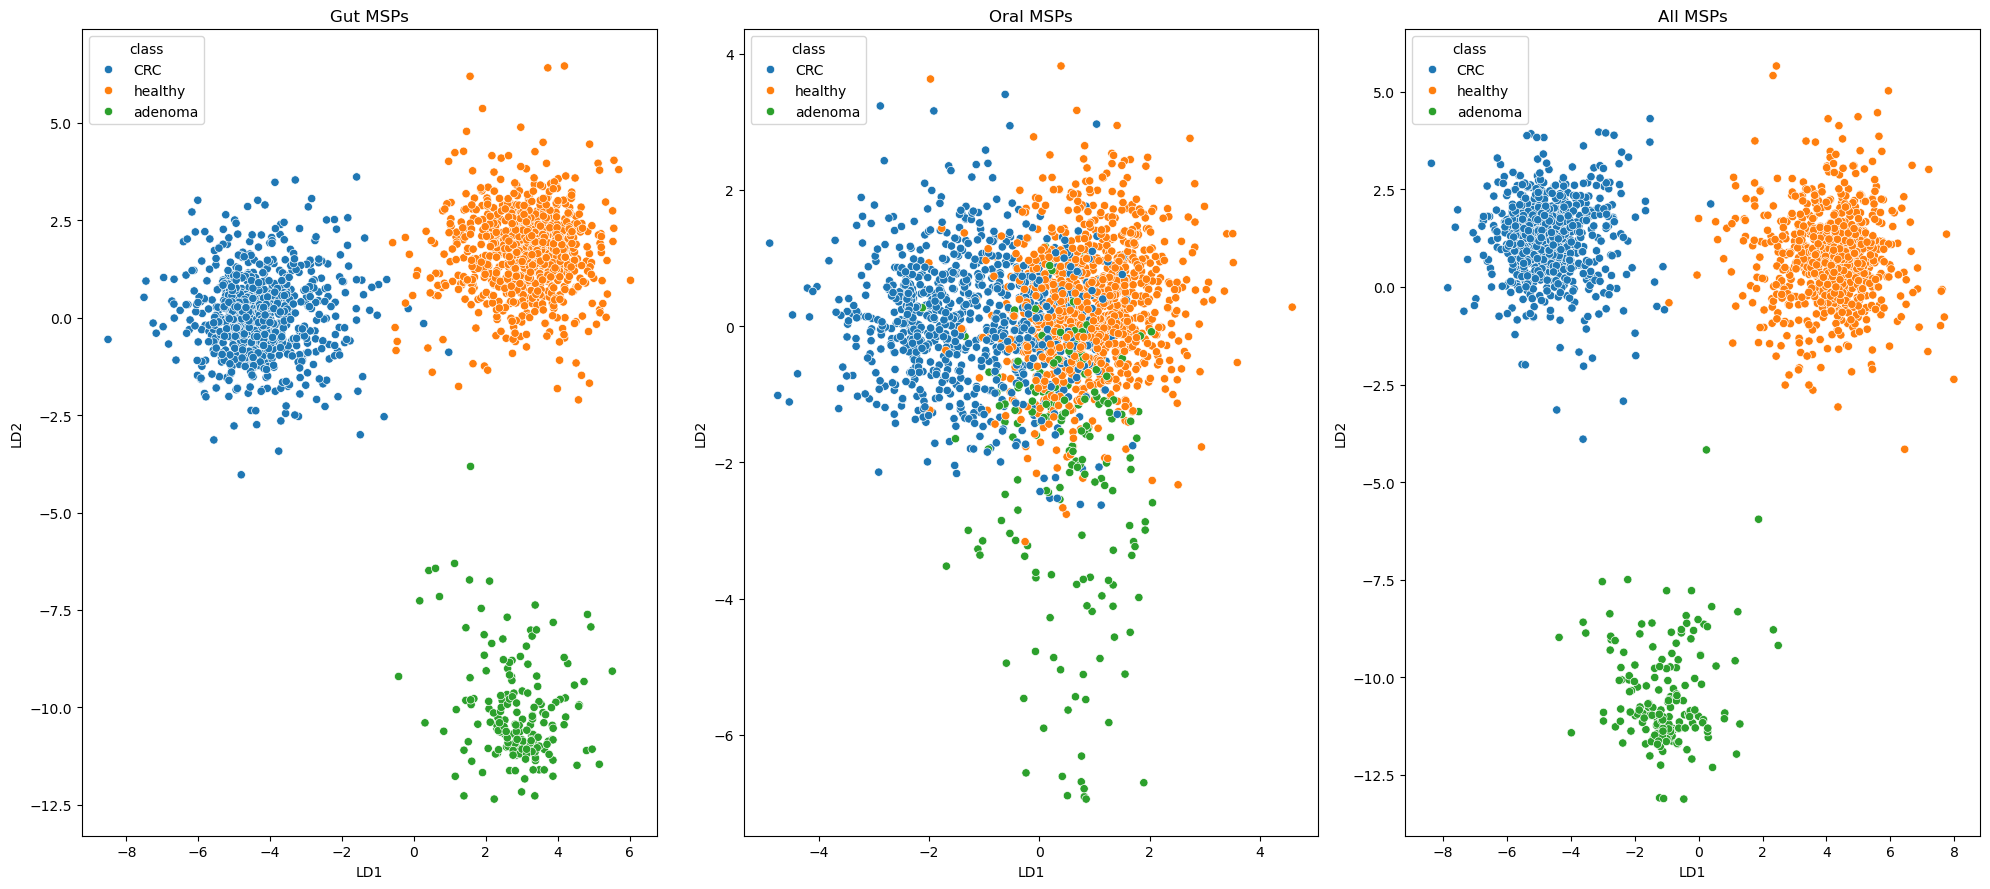

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(20, 9))

# left
sns.scatterplot(data=gut_LDA_df, x='LD1', y='LD2', hue='class', ax=axes[0])
axes[0].set_title('Gut MSPs')

# middle
sns.scatterplot(data=oral_LDA_df, x='LD1', y='LD2', hue='class', ax=axes[1])
axes[1].set_title('Oral MSPs')
axes[1].legend(loc='upper left', title='class')

# right
sns.scatterplot(data=total_LDA_df, x='LD1', y='LD2', hue='class', ax=axes[2])
axes[2].set_title('All MSPs')

plt.tight_layout()
plt.show()

## PCA of total MSPs and gut MSPs

In [164]:
min_max = MinMaxScaler()

gut_scaled = min_max.fit_transform(gut_X)
total_scaled = min_max.fit_transform(total_X)

pca_gut = PCA()
pca_total = PCA()

pca_gut_data = pca_gut.fit_transform(gut_scaled)
pca_total_data = pca_total.fit_transform(total_scaled)

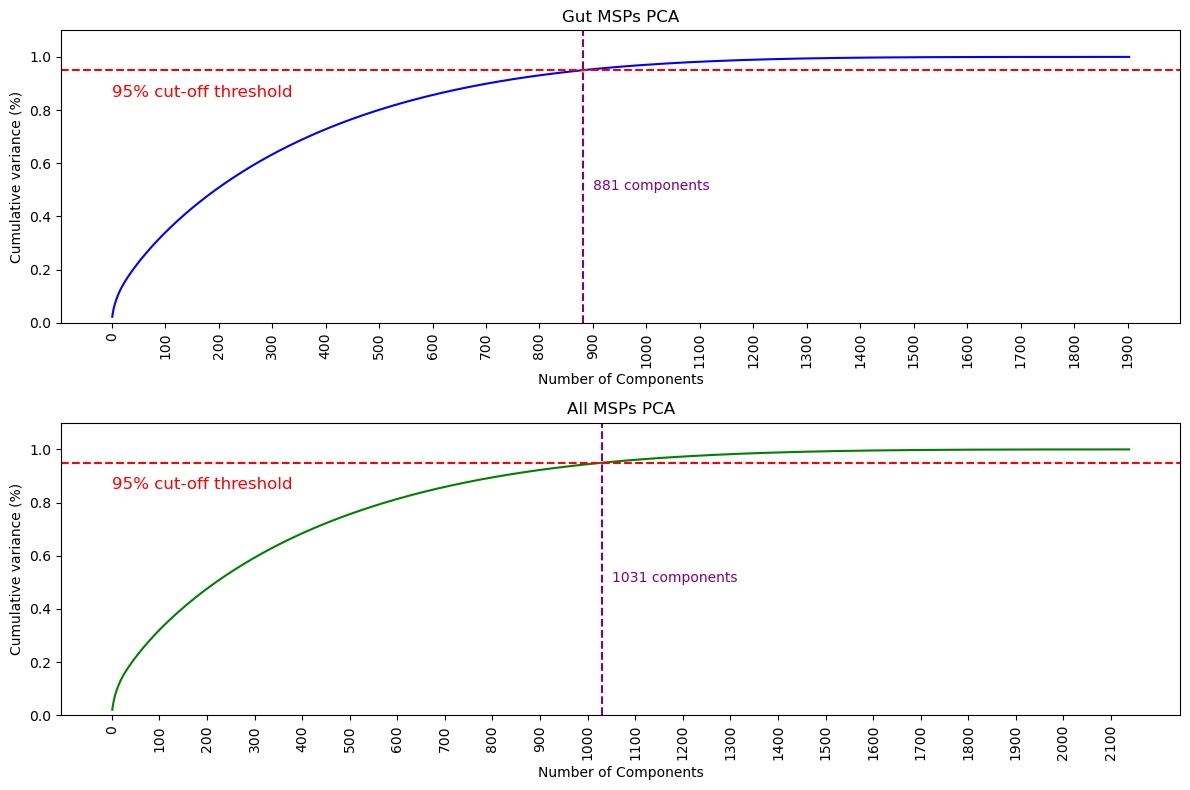

In [166]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))

# top row -- gut MSPs
xi_gut = np.arange(1, len(pca_gut.explained_variance_ratio_) + 1)
y_gut = np.cumsum(pca_gut.explained_variance_ratio_)
n_gut = np.argmax(y_gut >= 0.95) + 1

ax[0].plot(xi_gut, y_gut, linestyle='-', color='b')
ax[0].set_ylim(0.0, 1.1)
ax[0].set_xticks(np.arange(0, len(xi_gut) + 1, step=100))
ax[0].set_xlabel('Number of Components')
ax[0].set_ylabel('Cumulative variance (%)')
ax[0].set_title('Gut MSPs PCA')
ax[0].axhline(y=0.95, color='r', linestyle='--')
ax[0].text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=12)
ax[0].axvline(x=n_gut, color='purple', linestyle='--')
ax[0].text(n_gut+20, 0.5, f"{n_gut} components", color='purple')

# bottom row
xi_total = np.arange(1, len(pca_total.explained_variance_ratio_) + 1)
y_total = np.cumsum(pca_total.explained_variance_ratio_)
n_total = np.argmax(y_total >= 0.95) + 1

ax[1].plot(xi_total, y_total, linestyle='-', color='g')
ax[1].set_ylim(0.0, 1.1)
ax[1].set_xticks(np.arange(0, len(xi_total) + 1, step=100))
ax[1].set_xlabel('Number of Components')
ax[1].set_ylabel('Cumulative variance (%)')
ax[1].set_title('All MSPs PCA')
ax[1].axhline(y=0.95, color='r', linestyle='--')
ax[1].text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=12)
ax[1].axvline(x=n_total, color='purple', linestyle='--')
ax[1].text(n_total+20, 0.5, f"{n_total} components", color='purple')

# change x tick label angles
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [168]:
# number of components to reach 95% variance explained
n_gut = np.argmax(y_gut >= 0.95) + 1
n_total = np.argmax(y_total >= 0.95) + 1

print(f"Gut MSPs: {n_gut} components explain 95% cumulative variance")
print(f"All MSPs: {n_total} components explain 95% cumulative variance")

Gut MSPs: 881 components explain 95% cumulative variance
All MSPs: 1031 components explain 95% cumulative variance


In [170]:
# this tells us which MSPs contribute to which PCs
gut_loadings = pd.DataFrame(
    pca_gut.components_.T,
    index=gut_X.columns.to_list(),
    columns=[f"PC{i+1}" for i in range(pca_gut.n_components_)]
)

total_loadings = pd.DataFrame(
    pca_total.components_.T,
    index=total_X.columns.to_list(),
    columns=[f"PC{i+1}" for i in range(pca_total.n_components_)]
)

pc1_gut = gut_loadings.iloc[:, :1].sort_values(by='PC1')
pc2_gut = gut_loadings.iloc[:, 1:2].sort_values(by='PC2')

pc1_total = total_loadings.iloc[:, :1].sort_values(by='PC1')
pc2_total = total_loadings.iloc[:, 1:2].sort_values(by='PC2')

# % variance explained by first 2 PCs
print(pca_gut.explained_variance_ratio_[:2])     # PC1 explains 2.2%, PC2 explains 1.4%
print(pca_total.explained_variance_ratio_[:2])   # PC1 explains 2.1%, PC2 explains 1.3%

[0.02242259 0.01370351]
[0.02064672 0.01270525]


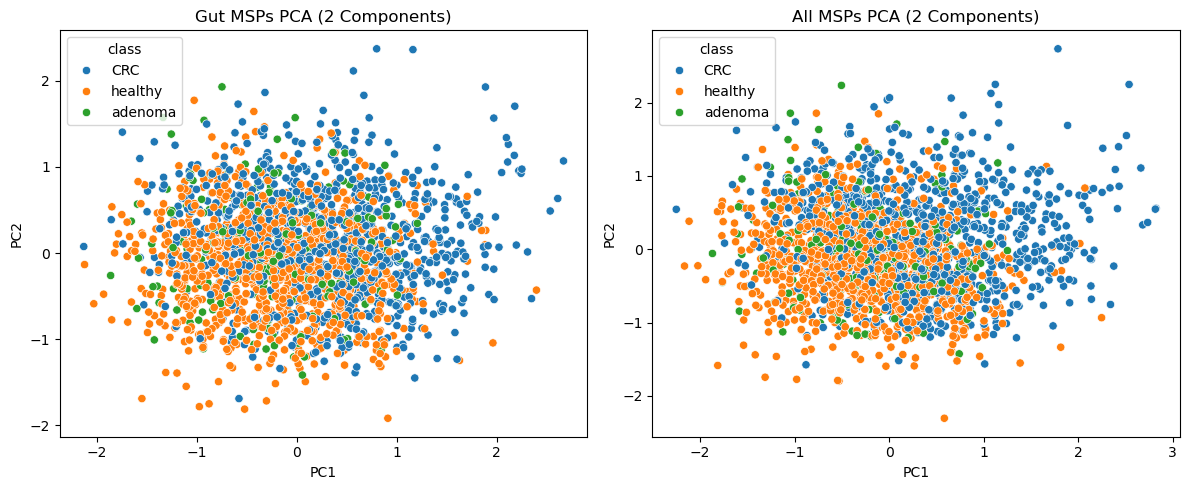

In [200]:
pca_gut_data = pd.DataFrame(
    pca_gut_data,
    index=gut_X.index,
    columns=[f'PC{i+1}' for i in range(pca_gut_data.shape[1])]
)

pca_total_data = pd.DataFrame(
    pca_total_data,
    index=total_X.index,
    columns=[f'PC{i+1}' for i in range(pca_total_data.shape[1])]
)

pca_gut_data['class'] = gut_y
pca_total_data['class'] = total_y

# PCA scatterplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# left
sns.scatterplot(x=pca_gut_data['PC1'], y=pca_gut_data['PC2'], hue=pca_gut_data['class'], ax=axes[0])
axes[0].set_title("Gut MSPs PCA (2 Components)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# left
sns.scatterplot(x=pca_total_data['PC1'], y=pca_total_data['PC2'], hue=pca_total_data['class'], ax=axes[1])
axes[1].set_title("All MSPs PCA (2 Components)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()

# Model Building

In [52]:
# splitting the data
total_X_train, total_X_test, total_y_train, total_y_test = train_test_split(total_X,
                                                                            total_y, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=total_y)

print(total_X_train.shape)
print(total_X_test.shape)
print(total_y_train.shape)
print(total_y_test.shape)

(1710, 2543)
(428, 2543)
(1710,)
(428,)


In [53]:
gut_X_train, gut_X_test, gut_y_train, gut_y_test = train_test_split(gut_X, 
                                                                    gut_y, 
                                                                    test_size=0.2, 
                                                                    random_state=42,
                                                                    stratify=gut_y)

print(gut_X_train.shape)
print(gut_X_test.shape)
print(gut_y_train.shape)
print(gut_y_test.shape)

(1710, 1903)
(428, 1903)
(1710,)
(428,)


In [80]:
# defining the pipelines
set_config(display="diagram")

scaler = MinMaxScaler()
pca = PCA(random_state=52, n_components=0.95)
ovr_log = OneVsRestClassifier(LogisticRegression(random_state=52))
random_forest = RandomForestClassifier(n_estimators=1000, random_state=52)
mlp = MLPClassifier(random_state=52, early_stopping=True)
elm = ELMClassifier(random_state=52)

logistic_model = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('ovr_log', ovr_log)
])

random_forest_model = Pipeline([
    ('pca', pca),
    ('random_forest', random_forest)
])

mlp_model = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('mlp', mlp)
])

elm_model = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('elm', elm)
])

In [82]:
# hyperparameter tuning with cross-validation
search_spaces = {
    "LR": {
        "ovr_log__estimator__C": Real(1e-6, 1e+1, prior='log-uniform'),
        "ovr_log__estimator__penalty": Categorical(['l1', 'l2']),
        "ovr_log__estimator__solver": Categorical(['liblinear', 'saga']),
        "ovr_log__estimator__max_iter": Integer(10000, 20000)
    },
    "RF": {
        "random_forest__max_depth": Integer(1, 40),
        "random_forest__min_samples_split": Integer(2, 50),
        "random_forest__min_samples_leaf": Integer(1, 10)
    },
    "MLP": {
        "mlp__activation": Categorical(['relu', 'tanh']),
        "mlp__alpha": Real(1e-5, 1e-1, prior='log-uniform'),
        "mlp__learning_rate": Categorical(['constant', 'adaptive']),
        "mlp__max_iter": Integer(10000, 20000)
    },
    "ELM": {
        "elm__alpha": Real(1e-7, 1e-1, prior='log-uniform'),
        "elm__n_neurons": Integer(20, 100),
        "elm__density": Real(1e-6, 1, prior='uniform')
    }
  }

'''
def hyperparameter_tuning(X_train, y_train):
  best_estimators = {}                                                          # initialize the dictionary that will collect the best models

  for model, name, search_space in zip([logistic_model, random_forest_model, mlp_model],
                                       ["LogisticRegression", "RandomForest", "MultilayerPerceptron"],
                                       [search_spaces["LR"], search_spaces["RF"], search_spaces["MLP"]]):
    optimizer = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        n_iter=100,
        cv=5,
        scoring="roc_auc_ovr_weighted",
        refit="roc_auc_ovr_weighted",
        return_train_score=True,
        random_state=52,
        verbose=0
    )
    optimizer.fit(X_train, y_train)

    print(f"Best hyperparameters for {name} model: {optimizer.best_params_}")
    print(f"Best score for {name} model: {optimizer.best_score_}")
    print("\n")

    best_estimators[name] = optimizer.best_estimator_                           # this stores the best estimator in an empty dictionary

  return best_estimators
'''

'\ndef hyperparameter_tuning(X_train, y_train):\n  best_estimators = {}                                                          # initialize the dictionary that will collect the best models\n\n  for model, name, search_space in zip([logistic_model, random_forest_model, mlp_model],\n                                       ["LogisticRegression", "RandomForest", "MultilayerPerceptron"],\n                                       [search_spaces["LR"], search_spaces["RF"], search_spaces["MLP"]]):\n    optimizer = BayesSearchCV(\n        estimator=model,\n        search_spaces=search_space,\n        n_iter=100,\n        cv=5,\n        scoring="roc_auc_ovr_weighted",\n        refit="roc_auc_ovr_weighted",\n        return_train_score=True,\n        random_state=52,\n        verbose=0\n    )\n    optimizer.fit(X_train, y_train)\n\n    print(f"Best hyperparameters for {name} model: {optimizer.best_params_}")\n    print(f"Best score for {name} model: {optimizer.best_score_}")\n    print("\n")\n\n   

In [84]:
LR_tuned = BayesSearchCV(
    estimator=logistic_model,
    search_spaces=search_spaces['LR'],
    n_iter=60,
    cv=5,
    scoring='roc_auc_ovr_weighted',
    refit='roc_auc_ovr_weighted',
    return_train_score=True,
    random_state=52,
    verbose=0
)

LR_tuned

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                        ('pca',
                                         PCA(n_components=0.95,
                                             random_state=52)),
                                        ('ovr_log',
                                         OneVsRestClassifier(estimator=LogisticRegression(random_state=52)))]),
              n_iter=60, random_state=52, refit='roc_auc_ovr_weighted',
              return_train_score=True, scoring='roc_auc_ovr_weighted',
              search_spaces={'ovr_log__estimator__C': Real(low=1e-06, high=10.0, prior='log-uniform', transform='identity'),
                             'ovr_log__estimator__max_iter': Integer(low=10000, high=20000, prior='uniform', transform='identity'),
                             'ovr_log__estimator__penalty': Categorical(categories=('l1', 'l2'), prior=None),
                             'ovr_log__estimator__solver': Categorical(categories=('liblinear', 'saga'), prior=None)})

In [86]:
RF_tuned = BayesSearchCV(
    estimator=random_forest_model,
    search_spaces=search_spaces['RF'],
    n_iter=60,
    cv=5,
    scoring='roc_auc_ovr_weighted',
    refit='roc_auc_ovr_weighted',
    return_train_score=True,
    random_state=52,
    verbose=0
)

RF_tuned

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('pca',
                                         PCA(n_components=0.95,
                                             random_state=52)),
                                        ('random_forest',
                                         RandomForestClassifier(n_estimators=1000,
                                                                random_state=52))]),
              n_iter=60, random_state=52, refit='roc_auc_ovr_weighted',
              return_train_score=True, scoring='roc_auc_ovr_weighted',
              search_spaces={'random_forest__max_depth': Integer(low=1, high=40, prior='uniform', transform='identity'),
                             'random_forest__min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='identity'),
                             'random_forest__min_samples_split': Integer(low=2, high=50, prior='uniform', transform='identity')})

In [88]:
MLP_tuned = BayesSearchCV(
    estimator=mlp_model,
    search_spaces=search_spaces['MLP'],
    n_iter=60,
    cv=5,
    scoring='roc_auc_ovr_weighted',
    refit='roc_auc_ovr_weighted',
    return_train_score=True,
    random_state=52,
    verbose=0
)

MLP_tuned

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                        ('pca',
                                         PCA(n_components=0.95,
                                             random_state=52)),
                                        ('mlp',
                                         MLPClassifier(early_stopping=True,
                                                       random_state=52))]),
              n_iter=60, random_state=52, refit='roc_auc_ovr_weighted',
              return_train_score=True, scoring='roc_auc_ovr_weighted',
              search_spaces={'mlp__activation': Categorical(categories=('relu', 'tanh'), prior=None),
                             'mlp__alpha': Real(low=1e-05, high=0.1, prior='log-uniform', transform='identity'),
                             'mlp__learning_rate': Categorical(categories=('constant', 'adaptive'), prior=None),
                             'mlp__max_iter': Integer(low=10000, high=20000, prior='uniform', transform='identity')})

In [90]:
ELM_tuned = BayesSearchCV(
    estimator=elm_model,
    search_spaces=search_spaces['ELM'],
    n_iter=60,
    cv=5,
    scoring='roc_auc_ovr_weighted',
    refit='roc_auc_ovr_weighted',
    return_train_score=True,
    random_state=52,
    verbose=0
)

ELM_tuned

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                        ('pca',
                                         PCA(n_components=0.95,
                                             random_state=52)),
                                        ('elm',
                                         ELMClassifier(random_state=52))]),
              n_iter=60, random_state=52, refit='roc_auc_ovr_weighted',
              return_train_score=True, scoring='roc_auc_ovr_weighted',
              search_spaces={'elm__alpha': Real(low=1e-07, high=0.1, prior='log-uniform', transform='identity'),
                             'elm__density': Real(low=1e-06, high=1, prior='uniform', transform='identity'),
                             'elm__n_neurons': Integer(low=20, high=100, prior='uniform', transform='identity')})

## All MSPs

In [76]:
# logistic regression model, wrapped by OvR Classifier
LR_tuned.fit(total_X_train, total_y_train)

best_total_LR_score = LR_tuned.best_score_
best_total_LR_params = LR_tuned.best_params_
total_LR_model = LR_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="total_LR_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_total_LR_score)
    log_params(best_total_LR_params)
    total_LR_model_info = log_model(total_LR_model, name="total_LR_model",
              input_example=total_X_train,
              registered_model_name="total_LR_model")

    # tag to remind what model is used for
    mlflow.set_tag("model_type", "total_LR")

Registered model 'total_LR_model' already exists. Creating a new version of this model...
Created version '8' of model 'total_LR_model'.


In [78]:
print(best_total_LR_score)
total_LR_model

0.8244747731583562


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.95, random_state=52)),
                ('ovr_log',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.28183429316811426,
                                                                  max_iter=20000,
                                                                  penalty='l1',
                                                                  random_state=52,
                                                                  solver='liblinear')))])

In [92]:
# random forest model
RF_tuned.fit(total_X_train, total_y_train)

best_total_RF_score = RF_tuned.best_score_
best_total_RF_params = RF_tuned.best_params_
total_RF_model = RF_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="total_RF_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_total_RF_score)
    log_params(best_total_RF_params)
    total_RF_model_info = log_model(total_RF_model, name="total_RF_model",
              input_example=total_X_train,
              registered_model_name="total_RF_model")

    # tag to remind what model is used for
    mlflow.set_tag("model_type", "total_RF")

Registered model 'total_RF_model' already exists. Creating a new version of this model...
Created version '5' of model 'total_RF_model'.


In [94]:
print(best_total_RF_score)
total_RF_model

0.7764028756987662


Pipeline(steps=[('pca', PCA(n_components=0.95, random_state=52)),
                ('random_forest',
                 RandomForestClassifier(max_depth=6, min_samples_leaf=2,
                                        min_samples_split=7, n_estimators=1000,
                                        random_state=52))])

In [202]:
# multilayer perceptron model
MLP_tuned.fit(total_X_train, total_y_train)

best_total_mlp_score = MLP_tuned.best_score_
best_total_mlp_params = MLP_tuned.best_params_
total_MLP_model = MLP_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="total_MLP_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_total_mlp_score)
    log_params(best_total_mlp_params)
    total_MLP_model_info = log_model(total_MLP_model, name="total_MLP_model",
              input_example=total_X_train,
              registered_model_name="total_MLP_model")

    # tag to remind what model is used for
    mlflow.set_logged_model_tags(
        total_MLP_model_info.model_id, {"Model Building": "HP-Tuned MLP model for all MSPs"}
    )

Registered model 'total_MLP_model' already exists. Creating a new version of this model...
Created version '2' of model 'total_MLP_model'.


In [204]:
print(best_total_mlp_score)
total_MLP_model

0.7939265527672281


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.95, random_state=52)),
                ('mlp',
                 MLPClassifier(alpha=0.08091715681078603, early_stopping=True,
                               learning_rate='adaptive', max_iter=19863,
                               random_state=52))])

In [206]:
# extreme learning machine model
ELM_tuned.fit(total_X_train, total_y_train)

best_total_elm_score = ELM_tuned.best_score_
best_total_elm_params = ELM_tuned.best_params_
total_ELM_model = ELM_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="total_ELM_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_total_elm_score)
    log_params(best_total_elm_params)
    total_ELM_model_info = log_model(total_ELM_model, name="total_ELM_model",
              input_example=total_X_train,
              registered_model_name="total_ELM_model")

    # tag to remind what model is used for
    mlflow.set_logged_model_tags(
        total_ELM_model_info.model_id, {"Model Building": "HP-Tuned ELM model for all MSPs"}
    )

Registered model 'total_ELM_model' already exists. Creating a new version of this model...
Created version '2' of model 'total_ELM_model'.


In [208]:
print(best_total_elm_score)
total_ELM_model

0.7626501903838792


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.95, random_state=52)),
                ('elm',
                 ELMClassifier(alpha=0.1, density=0.7938311852960555,
                               n_neurons=100, random_state=52))])

## Gut MSPs

In [211]:
# logistic regression model, wrapped by OvR Classifier
LR_tuned.fit(gut_X_train, gut_y_train)

best_gut_LR_score = LR_tuned.best_score_
best_gut_LR_params = LR_tuned.best_params_
gut_LR_model = LR_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="gut_LR_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_gut_LR_score)
    log_params(best_gut_LR_params)
    gut_LR_model_info = log_model(gut_LR_model, name="gut_LR_model",
              input_example=gut_X_train,
              registered_model_name="gut_LR_model")

    # tag to remind what model is used for
    mlflow.set_logged_model_tags(
        gut_LR_model_info.model_id, {"Model Building": "HP-Tuned LR model for gut MSPs"}
    )

Registered model 'gut_LR_model' already exists. Creating a new version of this model...
Created version '2' of model 'gut_LR_model'.


In [213]:
print(best_gut_LR_score)
gut_LR_model

0.7903704821387801


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.95, random_state=52)),
                ('ovr_log',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.03483297988143859,
                                                                  max_iter=10000,
                                                                  random_state=52,
                                                                  solver='saga')))])

In [ ]:
# random forest model
RF_tuned.fit(gut_X_train, gut_y_train)

best_gut_RF_score = RF_tuned.best_score_
best_gut_RF_params = RF_tuned.best_params_
gut_RF_model = RF_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="gut_RF_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_gut_RF_score)
    log_params(best_gut_RF_params)
    gut_RF_model_info = log_model(gut_RF_model, name="gut_RF_model",
              input_example=gut_X_train,
              registered_model_name="gut_RF_model")

    # tag to remind what model is used for
    mlflow.set_logged_model_tags(
        gut_RF_model_info.model_id, {"Model Building": "HP-Tuned RF model for gut MSPs"}
    )

In [167]:
print(best_gut_RF_score)
gut_RF_model

0.8166596829778839


Pipeline(steps=[('random_forest',
                 RandomForestClassifier(max_depth=26, n_estimators=1000,
                                        random_state=52))])

In [171]:
# multilayer perceptron model
MLP_tuned.fit(gut_X_train, gut_y_train)

best_gut_mlp_score = MLP_tuned.best_score_
best_gut_mlp_params = MLP_tuned.best_params_
gut_MLP_model = MLP_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="gut_MLP_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_gut_mlp_score)
    log_params(best_gut_mlp_params)
    gut_MLP_model_info = log_model(gut_MLP_model, name="gut_MLP_model",
              input_example=gut_X_train,
              registered_model_name="gut_MLP_model")

    # tag to remind what model is used for
    mlflow.set_logged_model_tags(
        gut_MLP_model_info.model_id, {"Model Building": "HP-Tuned MLP model for gut MSPs"}
    )

C:\Users\gtapa\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'gut_MLP_model'.
Created version '1' of model 'gut_MLP_model'.


In [175]:
print(best_gut_mlp_score)
gut_MLP_model

0.6467832588395822


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='tanh', alpha=0.005837394052459063,
                               early_stopping=True, learning_rate='adaptive',
                               max_iter=20000, random_state=52))])

In [177]:
# extreme learning machine model
ELM_tuned.fit(gut_X_train, gut_y_train)

best_gut_elm_score = ELM_tuned.best_score_
best_gut_elm_params = ELM_tuned.best_params_
gut_ELM_model = ELM_tuned.best_estimator_

# run MLflow experiment
with start_run(run_name="gut_ELM_BayesSearchCV"):

    # log everything
    log_metric("roc_auc_weighted", best_gut_elm_score)
    log_params(best_gut_elm_params)
    gut_ELM_model_info = log_model(gut_ELM_model, name="gut_ELM_model",
              input_example=gut_X_train,
              registered_model_name="gut_ELM_model")

    # tag to remind what model is used for
    mlflow.set_logged_model_tags(
        gut_ELM_model_info.model_id, {"Model Building": "HP-Tuned ELM model for gut MSPs"}
    )

C:\Users\gtapa\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Successfully registered model 'gut_ELM_model'.
Created version '1' of model 'gut_ELM_model'.


In [179]:
print(best_gut_elm_score)
gut_ELM_model

0.6838394778902408


Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=98, random_state=52)),
                ('elm',
                 ELMClassifier(alpha=1.28378389752755e-07,
                               density=0.2353925594412314, n_neurons=72,
                               random_state=52))])

# Evaluating the Model

In [229]:
# evaluate the model on test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=1))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba, average='weighted', multi_class='ovr'))

## All MSPs

In [231]:
# logistic regression model
evaluate_model(total_LR_model, total_X_test, total_y_test)

Accuracy: 0.633177570093458
Precision: 0.6031589743041107
Recall: 0.633177570093458
F1 Score: 0.605712233556367
ROC-AUC Score: 0.7253910668770481


In [233]:
# random forest model
evaluate_model(total_RF_model, total_X_test, total_y_test)

Accuracy: 0.705607476635514
Precision: 0.7422358914000943
Recall: 0.705607476635514
F1 Score: 0.6739325645929182
ROC-AUC Score: 0.7904777481085892


In [235]:
# MLP model
evaluate_model(total_MLP_model, total_X_test, total_y_test)

Accuracy: 0.4953271028037383
Precision: 0.557532500909177
Recall: 0.4953271028037383
F1 Score: 0.5173204247403419
ROC-AUC Score: 0.6538064355167158


In [237]:
# ELM model
evaluate_model(total_ELM_model, total_X_test, total_y_test)

Accuracy: 0.6401869158878505
Precision: 0.6674349253993159
Recall: 0.6401869158878505
F1 Score: 0.6103689890631594
ROC-AUC Score: 0.693915813677496


## Gut MSPs

In [240]:
# logistic regression model
evaluate_model(gut_LR_model, gut_X_test, gut_y_test)

Accuracy: 0.633177570093458
Precision: 0.5988970213948385
Recall: 0.633177570093458
F1 Score: 0.6041399918032677
ROC-AUC Score: 0.7171322166929642


In [242]:
# random forest model
evaluate_model(gut_RF_model, gut_X_test, gut_y_test)

Accuracy: 0.6939252336448598
Precision: 0.7259511580599246
Recall: 0.6939252336448598
F1 Score: 0.663796089663151
ROC-AUC Score: 0.8056433291526749


In [244]:
# MLP model
evaluate_model(gut_MLP_model, gut_X_test, gut_y_test)

Accuracy: 0.544392523364486
Precision: 0.5866971828305264
Recall: 0.544392523364486
F1 Score: 0.5634715053781123
ROC-AUC Score: 0.6419519359145528


In [246]:
# ELM model
evaluate_model(gut_ELM_model, gut_X_test, gut_y_test)

Accuracy: 0.6238317757009346
Precision: 0.6136886046038172
Recall: 0.6238317757009346
F1 Score: 0.599904797957878
ROC-AUC Score: 0.6843156464511605
